# Presentation of Main Results: Dense Passage Retriever

This notebook presents the main results of our project. The data set used is TriviaQA from HuggingFace [https://github.com/huggingface/datasets] where samples from the train and validation set are used. After pre-processing data, both train and validation sets contain 1024 Q&A pairs which is used when creating the results. 

First the necessary modules are installed and imported, the drive is mounted and torch is setup to use the GPU.

In [2]:
%%capture
# Install modules from Hugging face
! pip install datasets;
! pip install transformers;

# Import used modules
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Setup Google Drive, where the raw data is located
import sys
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append(os.path.join('/content/drive/My Drive/deep_learning_project'))

Mounted at /content/drive


Google Colab is used to access a Tesla T4 GPU.

In [4]:
# Setup GPU
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Loading Data

Below two small samples of training and validation data are loaded.

In [5]:
from datasets import load_from_disk

train_path = 'drive/My Drive/deep_learning_project/train_mini'
val_path = 'drive/My Drive/deep_learning_project/validation_mini'

train_raw = load_from_disk(train_path)
validation_raw = load_from_disk(val_path)


The data can also be obtained by running the following:

In [ ]:
from datasets import load_dataset
train_raw = load_dataset('trivia_qa', name = 'rc', split = 'train')
validation_raw = load_dataset('trivia_qa', name = 'rc', split = 'validation')
train_raw = train_raw.select(range(2000))
validation_raw = validation_raw.select(range(2000))
train_raw = train_raw.map(remove_columns=(['search_results']))
validation_raw = validation_raw.map(remove_columns=(['search_results']))

The features of the data can be seen below:

In [6]:
train_raw.features

{'answer': {'aliases': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
  'matched_wiki_entity_name': Value(dtype='string', id=None),
  'normalized_aliases': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
  'normalized_matched_wiki_entity_name': Value(dtype='string', id=None),
  'normalized_value': Value(dtype='string', id=None),
  'type': Value(dtype='string', id=None),
  'value': Value(dtype='string', id=None)},
 'entity_pages': Sequence(feature={'doc_source': Value(dtype='string', id=None), 'filename': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'wiki_context': Value(dtype='string', id=None)}, length=-1, id=None),
 'question': Value(dtype='string', id=None),
 'question_id': Value(dtype='string', id=None),
 'question_source': Value(dtype='string', id=None)}

## Pre-process Data

The data is pre-processed before using it in the Dense Passage Retrieval. The process is described in section *3.2 Wikipedia Data Pre-processing* in the article.

Furthermore, we have defined several functions in order to calculate similarity, choose the positive passage, divide the documents into passages and appending a Q token for the BERT encoder which can be found below.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

def preprocess_data(data, paragraph_len = 128, remove_search_results = False):
    """
    Pre-processes the data by selecting relevant columns and finding the 
    paragraph with the correct answer .

    Parameters
    ----------
    data : datasets.Dataset
        The raw wiki_qa data - maybe with feature 'search_results' removed for 
        more efficient storage.
    paragraph_len : int, optional
        Number of words in paragraph. The default is 128.
    remove_search_results : bool, optional
        Remove feature 'search_results' from the data. The default is False.

    Returns
    -------
        datasets.dataset
    Pre processed dataset with columns 
    ['answer', 'paragraph', 'question', 'question_id'].
    """
   
    # Select appropriate columns
    if remove_search_results:
        data = data.map(remove_columns = ['search_results'])
    out_data = data.map(lambda example: {'wiki_text': example['entity_pages']['wiki_context'], 
                                         'wiki_title': example['entity_pages']['title'],
                                             'answer': example['answer']['normalized_value']}, 
                            remove_columns=['question_source', 'answer', 'entity_pages'])
    
    # Remove entries without wiki text
    out_data = out_data.filter(lambda example: len(example['wiki_text']) > 0)
    
    # Get paragraph with the answer
    out_data = out_data.map(lambda example: {
        'paragraph': get_paragraph_with_answer(example, paragraph_len)
        }, remove_columns = ['wiki_text', 'wiki_title'])
    
    out_data = out_data.map(lambda example: {
        'question': append_Q_token(example)
        })
    return(out_data)

def get_tfidf_similarity(questions, paragraphs):
    """
    Returns a similarity matrix based on the distance in the tf-idf space

    Parameters
    ----------
    questions : list of strings
        Lists of all questions.
    paragraphs : list of strings
        Lists of all paragraphs
    
    Returns :
    -------
        Similarity matrix of dimension  
        (number of questions, number of paragraphs). 
    """
    vectorizer = TfidfVectorizer(lowercase = False)
    all_text = questions + paragraphs
    vectorizer.fit(all_text)
    similarity = vectorizer.transform(questions) * vectorizer.transform(paragraphs).T
    return np.array(similarity.todense())

def get_paragraph_with_answer(example, paragraph_len):
    """
    Return paragraph of paragraph_len from example['wiki_text'] with highest 
    similary to question + answer
    """
    paragraphs = get_all_paragraphs(example, paragraph_len)
    
    # joining title and text without the '[P]' token 
    paragraphs_joined = [paragraphs[0][0][4:] + ' ' + paragraph[1] for paragraph in paragraphs]
    
    # Calculating tf-idf similarities
    target = example['question'] + example['answer'] 
    sim = get_tfidf_similarity([target], paragraphs_joined) 
        
    # finding most similar containing the answer
    n_para = sim.size
    idxs = np.argsort(sim)[0][-n_para:]
    for p in range(len(idxs)):
        idx = idxs[-p]
        if example['answer'] in paragraphs[idx][1]:
            break 
    
    answer_paragraph = paragraphs[idx]
    
    return answer_paragraph


def get_all_paragraphs(example, paragraph_len):
    """
    Splits all wiki_texts of example into paragraphs of paragraph_len
    """
    n_texts = len(example['wiki_text'])
    all_paragraphs = []
    tokenizer = RegexpTokenizer(r'\w+')
    for i in range(n_texts):
        tokens = tokenizer.tokenize(example['wiki_text'][i].lower())
        paragraphs = [tokens[i:(i+paragraph_len)] \
                      for i in range(0, len(tokens), paragraph_len)]
        
        paragraphs = [['[P] ' + example['wiki_title'][i].lower()] + [' '.join(paragraph)] for paragraph in paragraphs]
        
        all_paragraphs += paragraphs 
    return all_paragraphs
    
    
def append_Q_token(example):
    """
    Appends P or Q to the paragraph or Question
    """
    return(['[Q]'] + [example['question']])

In [ ]:
train_processed = preprocess_data(train_raw)
validation_processed = preprocess_data(validation_raw)

Loading cached processed dataset at drive/My Drive/deep_learning_project/train_mini/cache-7fb3e0a1fe57620e.arrow
Loading cached processed dataset at drive/My Drive/deep_learning_project/train_mini/cache-bda79a61790ad1cf.arrow
Loading cached processed dataset at drive/My Drive/deep_learning_project/train_mini/cache-695390877b1775da.arrow
Loading cached processed dataset at drive/My Drive/deep_learning_project/train_mini/cache-730875171f3c9dbf.arrow


## Training Models

When training the models we use a `BATCH_SIZE` of 16, a `learning_rate` at $5e-5$ and 4 `EPOCHS`.

In [ ]:
from math import ceil
from transformers import AutoTokenizer, BertModel, AdamW

In [ ]:
# Define data parameters
batch_size = 16

# Train
n_sample_train = 1024 
n_batches_train = ceil(n_sample_train/batch_size)
# Validation
n_sample_validation = 128 
n_batches_validation = ceil(n_sample_validation/batch_size)


# Define model parameters
lr = 5e-5
n_epochs = 4

# Define printing parameters
n_batch_print = 16 # Prints every (n_batch_print) during training

A subset of data is chosen and tokenized using the `AutoTokenizer` from the pretrained BERT base model. The tokens are used to define the input features for the model. 

In [ ]:
# Subset data
train_data = train_processed.select(range(n_sample_train))
validation_data = validation_processed.select(range(n_sample_validation))

# Tokenize data
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', padding = True)
train_data = train_data.map(lambda example: {
    'Q_input_ids': tokenizer(example['question'], padding = 'max_length')['input_ids'],
    'Q_attention_mask': tokenizer(example['question'], padding = 'max_length')['attention_mask'],
    'Q_token_type_ids': tokenizer(example['question'], padding = 'max_length')['token_type_ids'],
    'P_input_ids': tokenizer(example['paragraph'], padding = 'max_length')['input_ids'],
    'P_attention_mask': tokenizer(example['paragraph'], padding = 'max_length')['attention_mask'],
    'P_token_type_ids': tokenizer(example['paragraph'], padding = 'max_length')['token_type_ids']},
    batched = True, batch_size= batch_size)

validation_data = validation_data.map(lambda example: {
    'Q_input_ids': tokenizer(example['question'], padding = 'max_length')['input_ids'],
    'Q_attention_mask': tokenizer(example['question'], padding = 'max_length')['attention_mask'],
    'Q_token_type_ids': tokenizer(example['question'], padding = 'max_length')['token_type_ids'],
    'P_input_ids': tokenizer(example['paragraph'], padding = 'max_length')['input_ids'],
    'P_attention_mask': tokenizer(example['paragraph'], padding = 'max_length')['attention_mask'],
    'P_token_type_ids': tokenizer(example['paragraph'], padding = 'max_length')['token_type_ids']},
    batched = True, batch_size= batch_size)

# Change to pytorch format. 
train_data.set_format(type = 'torch', 
                        columns = ['Q_input_ids', 'Q_attention_mask', 'Q_token_type_ids',
                                   'P_input_ids', 'P_attention_mask', 'P_token_type_ids'])

validation_data.set_format(type = 'torch', 
                        columns = ['Q_input_ids', 'Q_attention_mask', 'Q_token_type_ids',
                                   'P_input_ids', 'P_attention_mask', 'P_token_type_ids'])

For fine-tuning the BERT model for DPR, we use a mini-batch training with the loss function defined in section *3.4 Fine-tuning of BERT Models*.  
All layers except for the last 3 layers of the network are freezed such that only the 3 outer layers are fine-tuned.

In [ ]:
# Define loss
def get_loss(sim):
    nll = -(torch.diagonal(sim) - torch.logsumexp(sim, dim = 1))
    return sum(nll)# return negative loss

# Get pre-trained model from hugging face
model = BertModel.from_pretrained('bert-base-uncased')

#Freezing all layers except the last ones
l11 = ["encoder.layer.11" in name[0] for name in model.named_parameters()]
l10 = ["encoder.layer.10" in name[0] for name in model.named_parameters()]
l9 = ["encoder.layer.9" in name[0] for name in model.named_parameters()]
layers_to_opt = list(map(any, zip(*[l9, l10, l11])))
params = [name[0] for name in model.named_parameters()]
param_to_be_optimized = [name for (layer, name) in zip(layers_to_opt, params) if layer]
for name, param in model.named_parameters():
  if not name in param_to_be_optimized:
    param.requires_grad = False

# Move model to cuda to train there
model.to(device)

optim = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = lr) # filter object works as a generator 

The weights that are updated in each layer (only 9th-11th is used here) and printed to get an overview. 

In [ ]:
# Print the weights that are being updated
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
tmp = count_parameters(model)

+----------------------------------------------------+------------+
|                      Modules                       | Parameters |
+----------------------------------------------------+------------+
|    encoder.layer.9.attention.self.query.weight     |   589824   |
|     encoder.layer.9.attention.self.query.bias      |    768     |
|     encoder.layer.9.attention.self.key.weight      |   589824   |
|      encoder.layer.9.attention.self.key.bias       |    768     |
|    encoder.layer.9.attention.self.value.weight     |   589824   |
|     encoder.layer.9.attention.self.value.bias      |    768     |
|   encoder.layer.9.attention.output.dense.weight    |   589824   |
|    encoder.layer.9.attention.output.dense.bias     |    768     |
| encoder.layer.9.attention.output.LayerNorm.weight  |    768     |
|  encoder.layer.9.attention.output.LayerNorm.bias   |    768     |
|     encoder.layer.9.intermediate.dense.weight      |  2359296   |
|      encoder.layer.9.intermediate.dense.bias  

The big training loop seen below is using a forward pass for both paragraphs and questions and concatenates the hidden layers as described in section *3.4 Fine-tuning of BERT Models*.
We use in-batch training such that we train on the positive and negative passages in each batch for every question. The purpose of this is to obtain great similarity matrices. 
As mentioned, this is the model where the 9th-11th layer is fine-tuned and concatenated, but the approach is similar for the other models described in the paper. 

In [ ]:
# The big loop
epoch_train_loss = [None]*n_batches_train
epoch_validation_loss = [None]*n_batches_validation
train_loss = [None]*n_epochs
validation_loss = [None]*n_epochs


for epoch in range(n_epochs):
    
    print(f'### EPOCH: {epoch+1}/{n_epochs} ###')

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    trainloader = iter(trainloader)
    validationloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    validationloader = iter(validationloader)
    
    # TRAINING MODEL
    model.train()
    for i, batch in enumerate(trainloader):
        if i % n_batch_print == 0:
          print(f'batch {i+1}/{len(trainloader)}')
        
        model.zero_grad()

        # Make forward pass for paragraphs
        input_ids = batch['P_input_ids'].to(device)
        attention_mask = batch['P_attention_mask'].to(device)
        token_type_ids = batch['P_token_type_ids'].to(device)
        P_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
        # concatenating hidden layers
        P_cat = torch.cat(tuple([P_encoded_layers.hidden_states[i] for i in [-3, -2, -1]]), dim=-1)  
        P_cat = P_cat[:, 0, :]
        
        # Make forward pass for questions
        input_ids = batch['Q_input_ids'].to(device)
        attention_mask = batch['Q_attention_mask'].to(device)
        token_type_ids = batch['Q_token_type_ids'].to(device)
        Q_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
        # concatenating hidden layers
        Q_cat = torch.cat(tuple([Q_encoded_layers.hidden_states[i] for i in [-3, -2, -1]]), dim=-1)  
        Q_cat = Q_cat[:, 0, :]

        # Calculate similarity matrix
        sim_matrix = torch.matmul(Q_cat, P_cat.T)

        # Get loss
        loss = get_loss(sim_matrix)

        # Update weights
        loss.backward()
        optim.step()

        # Save loss
        epoch_train_loss[i] = loss.item()

    # VALIDATING MODEL
    model.eval()
    for i, batch in enumerate(validationloader):

        # Make forward pass for paragraphs
        input_ids = batch['P_input_ids'].to(device)
        attention_mask = batch['P_attention_mask'].to(device)
        token_type_ids = batch['P_token_type_ids'].to(device)
        P_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
        
        # concatenating hidden layers
        P_cat = torch.cat(tuple([P_encoded_layers.hidden_states[i] for i in [-3, -2, -1]]), dim=-1)  
        P_cat = P_cat[:, 0, :]

        # Make forward pass for questions
        input_ids = batch['Q_input_ids'].to(device)
        attention_mask = batch['Q_attention_mask'].to(device)
        token_type_ids = batch['Q_token_type_ids'].to(device)
        Q_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
        
        # concatenating hidden layers
        Q_cat = torch.cat(tuple([Q_encoded_layers.hidden_states[i] for i in [-3, -2, -1]]), dim=-1)  
        Q_cat = Q_cat[:, 0, :]

        # Calculate similarity matrix
        sim_matrix = torch.matmul(Q_cat, P_cat.T)

        # Get loss
        loss = get_loss(sim_matrix)
        epoch_validation_loss[i] = loss.item()
        
    
    train_loss[epoch] = sum(epoch_train_loss)/len(epoch_train_loss)
    validation_loss[epoch] = sum(epoch_validation_loss)/len(epoch_validation_loss)
    
    print(f'train loss: {train_loss[epoch]:.2f}')
    print(f'validation loss: {validation_loss[epoch]:.2f}')


### EPOCH: 1/4 ###
batch 1/64


/usr/local/lib/python3.6/dist-packages/datasets/arrow_dataset.py:850: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(x, **format_kwargs)


batch 17/64
batch 33/64
batch 49/64
train loss: 409.36
validation loss: 45.81
### EPOCH: 2/4 ###
batch 1/64
batch 17/64
batch 33/64
batch 49/64
train loss: 84.02
validation loss: 16.92
### EPOCH: 3/4 ###
batch 1/64
batch 17/64
batch 33/64
batch 49/64
train loss: 37.52
validation loss: 8.96
### EPOCH: 4/4 ###
batch 1/64
batch 17/64
batch 33/64
batch 49/64
train loss: 23.78
validation loss: 9.21


The train loss and validation loss are illustrated for each epoch.

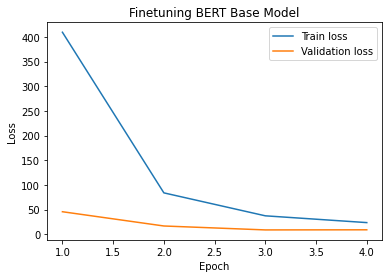

In [ ]:
fig = plt.figure()
plt.plot(range(1, n_epochs+1), train_loss, label = 'Train loss')
plt.plot(range(1, n_epochs+1), validation_loss, label = 'Validation loss')
plt.title('Finetuning BERT Base Model')
plt.ylabel('Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

The model is saved to avoid executing all code cells again and thus use unnecessary computation power. 

In [ ]:
#%% Saving model
model_path = 'drive/My Drive/deep_learning_project/Fine-tuned BERT models/presentation_notebook_model'
model.save_pretrained(model_path)

## Evaluate Performance

For evaluating the performance of the models (here the Fine-tuned BERT model where 9th-11th are concatenated) the following functions are defined. The functions finds the top $k$ paragraphs and the accuracy and a random retriever is also defined as a baseline model. 

In [ ]:
# Imports required to run functions

from random import sample

def get_top_k(similarity, question_ids, paragraph_ids, k):
    """
    Return the top k documents for based on similarity matrix

    Parameters
    ----------
    similarity : ndarray
        similarity matrix with shape (n_questions, n_paragraphs)
    question_ids : list of str
        List of the question ids
    paragraph_ids : list of str
        List of the paragraph ids (corresponding to the question id that the 
                                   paragraph belongs to)
    k : int
        Number or paragraphs to return

    Returns
    -------
    out : dict
        keys are the question ids, and each element contains list of the ids of the
        k nearest paragraphs
    """
    n_questions = similarity.shape[0]
    idxs = [np.argsort(similarity[row,:])[-k:][::-1] for row in range(n_questions)]
    out = {question_ids[i]:np.array(paragraph_ids)[idxs[i]] for i in range(n_questions)}
    return out

def get_accuracy(top_k):
    """ Returns accuracy. top_k is a dict as returned by get_top_k().  """
    n_correct = [(question in paragraphs) for question, paragraphs in top_k.items()]
    accuracy = sum(n_correct)/len(top_k)*100
    return accuracy


def get_tfidf_similarity(questions, paragraphs):
    """
    Returns a similarity matrix based on the distance in the tf-idf space

    Parameters
    ----------
    questions : list of strings
        Lists of all questions.
    paragraphs : list of strings
        Lists of all paragraphs
    
    Returns :
    -------
        Similarity matrix of dimension  
        (number of questions, number of paragraphs). 
    """
    vectorizer = TfidfVectorizer(lowercase = False)
    all_text = questions + paragraphs
    vectorizer.fit(all_text)
    similarity = vectorizer.transform(questions) * vectorizer.transform(paragraphs).T
    return np.array(similarity.todense())

def get_random_accuracy(k_list, n):
    max_k = max(k_list)
    top_k_list = [sample(range(n), max_k) for i in range(n)] # 
    accs = [None]*len(k_list)
    for i, k in enumerate(k_list): 
        n_correct = [(1 in top_k[0:k]) for top_k in top_k_list]
        accs[i] = sum(n_correct)/n*100
    return(accs)

def get_accuracy_vector(k_list, sim, question_ids, paragraph_ids):
    accs = [None]*len(k_list)
    for i, k in enumerate(k_list):
        top_k = get_top_k(sim, question_ids, paragraph_ids, k)
        accs[i] = get_accuracy(top_k)
    return accs

The similarity matrix based on BERT is computed differently as it uses forward pass to encode the paragraphs and questions. 

In [ ]:
def get_BERT_similarity(data, finetuned = False, model_name = 'bert-base-uncased', concatenate_9thTo11thLayer = False):
    """
    Returns a similarity matrix based on the distance in the BERT encoded space

    Parameters
    ----------
    questions : list of strings
        Lists of all questions.
    paragraphs : list of strings
        Lists of all paragraphs
    finetuned : bool
        Whether to use models that we have finetuned located in drive or download pre-trained models directly from HuggingFace
    model_name : string
        Name of model to use. Options = ['bert-base-uncased', 'bert-large-uncased', ']
    
    Returns :
    -------
        Similarity matrix of dimension  
        (number of questions, number of paragraphs). 
    """
    # Define tokenizer 
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', padding = True)

    # Define model
    if finetuned:
      folder_path = 'drive/My Drive/deep_learning_project/Fine-tuned BERT models/'
      model_path = folder_path + model_name
      model = BertModel.from_pretrained(model_path)
    else:
      model = BertModel.from_pretrained(model_name)
    
    model.to(device)
    batch_size = 16
    n_batch_print = 16
    
    # Tokenize data
    tokenized_data = data.map(lambda example: {
    'Q_input_ids': tokenizer(example['question'],padding = 'longest')['input_ids'],
    'Q_attention_mask': tokenizer(example['question'], padding = 'longest')['attention_mask'],
    'Q_token_type_ids': tokenizer(example['question'], padding = 'longest')['token_type_ids'],
    'P_input_ids': tokenizer(example['paragraph'],  padding = 'longest')['input_ids'],
    'P_attention_mask': tokenizer(example['paragraph'],  padding = 'longest')['attention_mask'],
    'P_token_type_ids': tokenizer(example['paragraph'],  padding = 'longest')['token_type_ids']},
    batched = True, batch_size= batch_size)

    tokenized_data.set_format(type = 'torch', 
                        columns = ['Q_input_ids', 'Q_attention_mask', 'Q_token_type_ids',
                                   'P_input_ids', 'P_attention_mask', 'P_token_type_ids'])
    dataloader = torch.utils.data.DataLoader(tokenized_data, batch_size=batch_size)
    dataloader = iter(dataloader)

    # Save encoded layers
    n_batches = len(dataloader)
    P_encoded_layers_list = [None]*n_batches
    Q_encoded_layers_list = [None]*n_batches

    
    with torch.no_grad():
      for i, batch in enumerate(dataloader):
        if i % n_batch_print == 0:
          print(f'batch {i+1}/{len(dataloader)}')

        # Make forward pass for paragraphs
        input_ids = batch['P_input_ids'].to(device)
        attention_mask = batch['P_attention_mask'].to(device)
        token_type_ids = batch['P_token_type_ids'].to(device)
        if concatenate_9thTo11thLayer == True:
          P_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
          P_encoded_layers_list[i] = torch.cat(tuple([P_encoded_layers.hidden_states[j] for j in [-3, -2, -1]]), dim=-1)[:, 0, :]
        else:
          P_encoded_layers_list[i] = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)[0][:, 0, :]
        
        # Make forward pass for questions
        input_ids = batch['Q_input_ids'].to(device)
        attention_mask = batch['Q_attention_mask'].to(device)
        token_type_ids = batch['Q_token_type_ids'].to(device)
        if concatenate_9thTo11thLayer == True:
          Q_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)
          Q_encoded_layers_list[i] = torch.cat(tuple([Q_encoded_layers.hidden_states[j] for j in [-3, -2, -1]]), dim=-1)[:, 0, :]
        else:
          Q_encoded_layers_list[i] = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)[0][:, 0, :]

    # Save encoded layers
    P_encoded_layers = torch.cat(P_encoded_layers_list, dim = 0)
    Q_encoded_layers = torch.cat(Q_encoded_layers_list, dim = 0)

    # Get similarity
    sim = torch.matmul(Q_encoded_layers, P_encoded_layers.T).cpu().numpy()

    return sim
  

The retrievers are evaluated on the validation split from TriviaQA - hence it is unseen data for all retrievers. 

In [ ]:
n_evaluation = 1024
k_list = [i+1 for i in range(100)]

validation_data = validation_processed.select(range(n_evaluation))

#%% Define inputs
questions_BERT = validation_data['question']
question_ids = validation_data['question_id']
paragraphs_BERT = validation_data['paragraph']
#%%
questions = [entry[0] + ' ' + entry[1] for entry in questions_BERT]
paragraphs = [entry[0] + ' ' + entry[1] for entry in paragraphs_BERT]

The similarity matrices are calculated for the models

In [ ]:
sim_tfidf = get_tfidf_similarity(questions, paragraphs)

In [ ]:
# Default base model (no finetuning)
sim_BERT = get_BERT_similarity(validation_data, concatenate_9thTo11thLayer = True)

# Fine-tuned model
sim_BERT_finetuned = get_BERT_similarity(validation_data, finetuned = True, model_name = 'presentation_notebook_model', concatenate_9thTo11thLayer = True)


batch 1/64
batch 17/64
batch 33/64
batch 49/64


Loading cached processed dataset at drive/My Drive/deep_learning_project/validation_mini/cache-f1725a924e9252a0.arrow


batch 1/64
batch 17/64
batch 33/64
batch 49/64


In [ ]:
#%% Get accuracies for a range of ks
acc_tfidf = get_accuracy_vector(k_list, sim_tfidf, question_ids, question_ids)
acc_bert = get_accuracy_vector(k_list, sim_BERT, question_ids, question_ids)
acc_bert_finedtuned = get_accuracy_vector(k_list, sim_BERT_finetuned, question_ids, question_ids)
acc_random = get_random_accuracy(k_list, n_evaluation)

The accuracy of the four models in this notebook are visualized as a function of $k$, i.e. the number of top paragraphs based on the similarity matrices. 

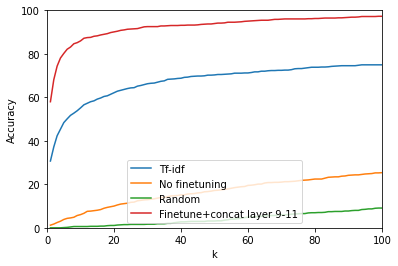

In [ ]:
fig = plt.figure()
plt.plot(k_list, acc_tfidf, label = 'Tf-idf')
plt.plot(k_list, acc_bert, label = 'No finetuning')
plt.plot(k_list, acc_random, label = 'Random')
plt.plot(k_list, acc_bert_finedtuned, label = 'Finetune+concat layer 9-11')
plt.ylim((0,100))
plt.xlim((0,100))
plt.legend(loc = 'lower center')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

We see that the fine-tuned BERT model performs the best. Note, the large difference between the BERT model with and without fine-tuning. Fine-tuning really matters. 

In [ ]:
import pandas as pd
all_accuracies = pd.DataFrame(list(zip(k_list, acc_random, acc_tfidf, acc_bert, acc_bert_finedtuned)), 
                              columns = ['k', 'random', 'tfidf', 'no_finetune', 'finetuned_9thTo11th'])
report_df = all_accuracies.copy()
report_df = report_df[report_df.k.isin([5,20,100])]
report_df = report_df.set_index('k')
report_df = report_df[['random', 'tfidf', 'no_finetune', 'finetuned_9thTo11th',]]
report_df = report_df.transpose()
report_df

k,5,20,100
random,0.097656,1.074219,9.082031
tfidf,48.383838,62.121212,74.949495
no_finetune,3.838384,10.000000,25.353535
finetuned_9thTo11th,80.202020,90.101010,97.272727
